In [1]:
from __future__ import annotations
from IPython.display import clear_output
clear_output(wait=True)  # wait=True waits for new output before clearing
#...
from pathlib import Path
from safetensors.torch import load_file
import itertools
from pydantic import BaseModel, ConfigDict
import numpy as np
import tqdm
import torch
from typing import List, Tuple, Literal, Dict

DATASETS = [
    # (numbers are counts for documents, there may be some longer documents -> slightly more chunks)
    "arguana", # 10K
    "fiqa", # 50K -> 20K
    "scidocs", # 25K -> 20K
    "nfcorpus", # 5K
    "hotpotqa", # 100K -> 20K
    "trec-covid", # too much -> 20K
]

MODEL_NAMES = [
    "WhereIsAI/UAE-Large-V1",
    "BAAI/bge-base-en-v1.5",
    "BAAI/bge-large-en-v1.5",
    "BAAI/bge-small-en-v1.5",
    "intfloat/e5-base-v2",
    "intfloat/e5-large-v2",
    "intfloat/e5-small-v2",
    "thenlper/gte-base",
    "thenlper/gte-large",
    "thenlper/gte-small",
    "sentence-transformers/gtr-t5-base",
    "sentence-transformers/gtr-t5-large",
    "mixedbread-ai/mxbai-embed-large-v1",
    "sentence-transformers/sentence-t5-base",
    "sentence-transformers/sentence-t5-large",
    "openai/text-embedding-3-large", # openai
    "openai/text-embedding-3-small", # openai
]

"""
TODO(Adriano) finish this (it might turn into a jupyter notebook idk)

This is an offline script to basically do the same thing as `quadracopter.ipynb`. It will provide functionality (through
multiple click commands) to:
1. Train optimal OLS and batched OLS for all pairs of embedding spaces, speeding up acquisition of our results by 1000x
2. Be able to calculate a set of visualizations that we need for the paper and store them somewhere
    - MAE Table
    - MSE Table
    - Variance Explained Table
    - MAE Explained Table
    - Aggregated of the above (using harmonic/arithmetic means)
    - CKA, Ranking Jaccard Similarity, and Rank score (to compare with the previous tables)
        - Cluster for CKA like the old paper
        - Sample a few random pairs of models and dataset and showcase the triplet loss
        - Cherry pick rank similarity from one model to all others and same for Jaccard like in the paper (this is done both in the
            bofore stitch section and in the after stitch section)
        - Table of rank similarity and jaccard similarity over top 10
    - Kernel maps
        - Sample a few random pairs of models and dataset and showcase the triplet loss
    - UMAP, PCA, and t-SNE for embeddings (combined with a clustering algorithm to get some labels on this shit)
        - Bonus: find some relevant labels for the chunks and then add that in there?
    - MSE/MAE of single cycle
    - Randomly sample some different transformations and calculate over-cycle performance (i.e. so we can see how long
        it takes to get error up by some percent like a half-life -> geometric mean)
    - Random matrix controls for CKA, Jaccard, MAE, MSE, etc... with sampling to provide error bars
(parses outputs from OLS or GD outputs and then creates this shit)
"""


paths_gd = [
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/arguana_hf_cartesian_product"),
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/nfcorpus_hf_cartesian_product"),
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/scidocs_hf_cartesian_product"),
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/trec-covid_hf_cartesian_product"),
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/fiqa_hf_cartesian_product"),
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/hotpotqa_hf_cartesian_product"),
]
paths_ols = [
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/ols_all_datasets")
]

class LossResultsLineEntry(BaseModel):
    epoch: int
    train_mse: float
    train_mae: float
    test_mse: float
    test_mae: float

class LossResults(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    train_mses: torch.Tensor
    train_maes: torch.Tensor
    validation_mses: torch.Tensor
    validation_maes: torch.Tensor

class StitchPair(BaseModel):
    source: str
    target: str
    dataset: str
    mode: Literal["affine", "affine_ols"] = "affine" 

class TableCreator:
    def __init__(self, paths: List[Path]):
        self.paths = paths

    def __load_stitch_info(self, path: Path) -> StitchPair:
        name = "stitch_info.json" if (path / "stitch_info.json").exists() else "stitch_info_pairs.json"
        with open(path / name, "r") as f:
            return StitchPair.model_validate_json(f.read())

    def __load_loss_results(self, path: Path) -> LossResults:
        with open(path / "log.jsonl", "r") as f:
            les = [LossResultsLineEntry.model_validate_json(line.strip()) for line in f if len(line.strip()) > 0]
        return LossResults(
            train_mses=torch.tensor([le.train_mse for le in les]),
            train_maes=torch.tensor([le.train_mae for le in les]),
            validation_mses=torch.tensor([le.test_mse for le in les]),
            validation_maes=torch.tensor([le.test_mae for le in les]),
        )

    def __get_minimal_mse_mae(self, loss_results: LossResults) -> torch.Tensor:
        train_mse, validation_mse = torch.min(loss_results.train_mses).item(), torch.min(loss_results.validation_mses).item()
        train_mae, validation_mae = torch.min(loss_results.train_maes).item(), torch.min(loss_results.validation_maes).item()
        return train_mse, validation_mse, train_mae, validation_mae

    def get_all_table_elements(self) -> Tuple[Dict[str, int], Dict[str, int], Dict[str, torch.Tensor], Dict[str, torch.Tensor]]:
        """
        Get a table of the minimal MSE and MAE out of all the models and datasets.
        """
        ################ 1. Load parent paths and sanity test ################
        jsonl_files = []
        # NOTE: log.jsonl = losses
        for path in self.paths:
            jsonl_files.extend(list(path.glob("**/*.jsonl")))
        # ---- Sanity Check Files Present ----
        parents = set([jsonl_file.parent for jsonl_file in jsonl_files])
        assert all((p / "log.jsonl").exists() for p in tqdm.tqdm(parents)) # get the losses that we will plit (i.e. MSEs and MAEs)
        assert all((p / "stitch_info.json").exists() or (p / "stitch_info_pairs.json").exists() for p in tqdm.tqdm(parents)) # get information about pair of models, etc...
        # TODO(Adriano) it appears that in some cases I forgot to measure this
        # assert all((p / "linear_transform.safetensors").exists() for p in tqdm.tqdm(parents)) # get layers if we care about it <--- technically not use rn, but sans
        info_losses: List[Tuple[StitchPair, LossResults]] = [
            (self.__load_stitch_info(p), self.__load_loss_results(p)) for p in parents
        ]
        # ---- Sanity Check Model-Dataset Pairs Used ----
        _expected_model_dataset_pairs_used = set(x for x in itertools.product(DATASETS, MODEL_NAMES, MODEL_NAMES) if x[1] != x[2]) # both directions, not equal
        for info, _ in tqdm.tqdm(info_losses):
            entry = (info.dataset, info.source, info.target)
            assert entry in _expected_model_dataset_pairs_used # Make sure not already passed
            _expected_model_dataset_pairs_used.remove(entry)
        if len(_expected_model_dataset_pairs_used) > 0:
            for entry in _expected_model_dataset_pairs_used: # [DEBUG]
                print(entry) # [DEBUG]
        assert len(_expected_model_dataset_pairs_used) == 0, f"Expected {len(_expected_model_dataset_pairs_used)} model-dataset pairs, got {len(info_losses)}"
        ################ 2. Populate the tables ################
        # TODO(Adriano) find a way to permute this intelligently?
        model2idx = {model: i for i, model in enumerate(MODEL_NAMES)}
        idx2model = {i: model for model, i in model2idx.items()}
        dataset2table_train_mse = {dataset: -1 * torch.ones(len(MODEL_NAMES), len(MODEL_NAMES)) for dataset in DATASETS}
        dataset2table_validation_mse = {dataset: -1 * torch.ones(len(MODEL_NAMES), len(MODEL_NAMES)) for dataset in DATASETS}
        dataset2table_train_mae = {dataset: -1 * torch.ones(len(MODEL_NAMES), len(MODEL_NAMES)) for dataset in DATASETS}
        dataset2table_validation_mae = {dataset: -1 * torch.ones(len(MODEL_NAMES), len(MODEL_NAMES)) for dataset in DATASETS}

        for info, loss_results in tqdm.tqdm(info_losses):
            # ---- Fetch indices ----
            src_idx, tgt_idx = model2idx[info.source], model2idx[info.target]
            # ---- Sanity Check ----
            assert dataset2table_train_mse[info.dataset][src_idx, tgt_idx] == -1, f"Dataset {info.dataset} already has a value at {src_idx, tgt_idx}"
            assert dataset2table_validation_mse[info.dataset][src_idx, tgt_idx] == -1, f"Dataset {info.dataset} already has a value at {src_idx, tgt_idx}"
            assert dataset2table_train_mae[info.dataset][src_idx, tgt_idx] == -1, f"Dataset {info.dataset} already has a value at {src_idx, tgt_idx}"
            assert dataset2table_validation_mae[info.dataset][src_idx, tgt_idx] == -1, f"Dataset {info.dataset} already has a value at {src_idx, tgt_idx}"
            # ---- Fill in da tables ----
            train_mse, validation_mse, train_mae, validation_mae = self.__get_minimal_mse_mae(loss_results)
            dataset2table_train_mse[info.dataset][src_idx, tgt_idx] = train_mse
            dataset2table_validation_mse[info.dataset][src_idx, tgt_idx] = validation_mse
            dataset2table_train_mae[info.dataset][src_idx, tgt_idx] = train_mae
            dataset2table_validation_mae[info.dataset][src_idx, tgt_idx] = validation_mae
        # ---- Fill diagonal with 0s ----
        for dataset in DATASETS:
            for i in range(len(MODEL_NAMES)):
                assert dataset2table_train_mse[dataset][i, i] == -1, f"Dataset {dataset} already has a value at {i, i}"
                assert dataset2table_validation_mse[dataset][i, i] == -1, f"Dataset {dataset} already has a value at {i, i}"
                assert dataset2table_train_mae[dataset][i, i] == -1, f"Dataset {dataset} already has a value at {i, i}"
                assert dataset2table_validation_mae[dataset][i, i] == -1, f"Dataset {dataset} already has a value at {i, i}"
                dataset2table_train_mse[dataset][i, i] = 0
                dataset2table_validation_mse[dataset][i, i] = 0
                dataset2table_train_mae[dataset][i, i] = 0
                dataset2table_validation_mae[dataset][i, i] = 0
        ################ 3. Sanity Check Tables were filled correctly ################
        assert all(0 <= d.min() <= d.max() for d in dataset2table_train_mse.values())
        assert all(0 <= d.min() <= d.max() for d in dataset2table_validation_mse.values())
        assert all(0 <= d.min() <= d.max() for d in dataset2table_train_mae.values())
        assert all(0 <= d.min() <= d.max() for d in dataset2table_validation_mae.values())
        # ret
        return model2idx, idx2model, dataset2table_train_mse, dataset2table_validation_mse, dataset2table_train_mae, dataset2table_validation_mae

In [2]:
creator1 = TableCreator(paths_gd)
creator2 = TableCreator(paths_ols)

In [3]:
(
    nnlinear_model2idx,
    nnlinear_idx2model,
    nnlinear_dataset2table_train_mse,
    nnlinear_dataset2table_validation_mse,
    nnlinear_dataset2table_train_mae,
    nnlinear_dataset2table_validation_mae
) = creator1.get_all_table_elements()
example_table = nnlinear_dataset2table_train_mse["arguana"]
print(example_table) # should be a nice torch tensor, 17 x 17


100%|██████████| 1632/1632 [00:00<00:00, 16471.92it/s]

tensor([[0.0000e+00, 2.1409e-04, 1.7688e-05, 3.8022e-04, 1.4615e-04, 1.2339e-04,
         2.5228e-04, 1.1638e-04, 3.3081e-05, 2.1894e-04, 2.3299e-04, 2.2096e-04,
         5.3694e-06, 9.4156e-05, 1.2276e-04, 1.1722e-04, 1.9921e-04],
        [1.9851e-04, 0.0000e+00, 1.8212e-04, 3.8609e-04, 1.3326e-04, 1.3031e-04,
         2.5906e-04, 4.0098e-05, 8.7585e-05, 2.2226e-04, 2.4388e-04, 2.3890e-04,
         1.8207e-04, 1.0100e-04, 1.3619e-04, 1.2865e-04, 2.1820e-04],
        [1.7824e-05, 2.1355e-04, 0.0000e+00, 3.8432e-04, 1.4492e-04, 1.2234e-04,
         2.5182e-04, 1.1819e-04, 3.5541e-05, 2.2295e-04, 2.3854e-04, 2.2654e-04,
         2.1329e-05, 9.6897e-05, 1.2671e-04, 1.1975e-04, 2.0493e-04],
        [2.4368e-04, 2.6703e-04, 2.2255e-04, 0.0000e+00, 1.7826e-04, 1.4847e-04,
         2.5177e-04, 1.4171e-04, 1.0531e-04, 6.8418e-05, 2.8192e-04, 2.7708e-04,
         2.2453e-04, 1.1663e-04, 1.5691e-04, 1.4592e-04, 2.5209e-04],
        [2.0576e-04, 2.0061e-04, 1.8838e-04, 4.1758e-04, 0.0000e+00, 1.1

In [4]:
from safetensors.torch import load_file
from tabulate import tabulate


def __get_model_files(model_dir: Path) -> List[Path]:
    return  [
            # embeddings
            model_dir / f"embeddings_corpus_train.safetensors",
            model_dir / f"embeddings_corpus_validation.safetensors",
            # model_dir / f"embeddings_queries_train.safetensors",
            # model_dir / f"embeddings_queries_validation.safetensors",
            # metadata
            # model_dir / f"metadatas_corpus_train.jsonl",
            # model_dir / f"metadatas_corpus_validation.jsonl",
            # model_dir / f"metadatas_queries_train.jsonl",
            # model_dir / f"metadatas_queries_validation.jsonl",
        ]
def __get_reversed_model_files(model_dir: Path) -> List[Path]:
    return [
        # reverse because sometimes we do "corpus_embeddings..."
        #
        # saftensors
        model_dir / f"corpus_train_embeddings.safetensors",
        # model_dir / f"queries_train_embeddings.safetensors",
        model_dir / f"corpus_validation_embeddings.safetensors",
        # model_dir / f"queries_validation_embeddings.safetensors",
        # jsonls
        # model_dir / f"corpus_train_metadatas.jsonl",
        # model_dir / f"queries_train_metadatas.jsonl",
        # model_dir / f"corpus_validation_metadatas.jsonl",
        # model_dir / f"queries_validation_metadatas.jsonl",
    ]

def get_model_files(model_dir: Path) -> List[Path]:
    files = __get_model_files(model_dir)
    if not all(f.exists() for f in files):
        files = __get_reversed_model_files(model_dir)
    assert all(f.exists() for f in files), f"Files {files} do not exist in {model_dir}"
    return files
    


embeddings_paths = [Path("/mnt/align3_drive/adrianoh/dl_final_project_embeddings")]
class EmbeddingsLoader:
    def __init__(self, paths: list[Path], device: torch.device = torch.device("cuda")):
        self.paths = paths
        self.model_names = MODEL_NAMES
        self.datasets = DATASETS
        self.device = device

    def get_mean_variance(self, embeddings: torch.Tensor) -> Tuple[torch.Tensor, float]:
        assert len(embeddings.shape) == 2, f"Embeddings must be 2D, got {embeddings.shape}"
        # (num_datapoints, num_features)
        # assert embeddings.shape[0] >= embeddings.shape[1], f"Embeddings must have more rows than columns, got {embeddings.shape}"
        mean_embeddings = embeddings.mean(dim=0)
        mean_centered = embeddings - mean_embeddings
        squares = mean_centered.pow(2)
        variance = squares.mean().item()
        return mean_embeddings, variance
    
    def get_mse_wrt_gaussian01(self, embeddings: torch.Tensor) -> float:
        return (embeddings - torch.randn_like(embeddings)).pow(2).mean().item()

    def get_all_embeddings(self) -> tuple[dict[str, torch.Tensor], dict[str, torch.Tensor]]:
        # Initialize storage
        # NOTE: we only do the corpus embeddings now!
        # all_embeddings_train: dict[Tuple[str, str], torch.Tensor] = {} # Might be used later
        # all_embeddings_validation: dict[Tuple[str, str], torch.Tensor] = {} # Might be used later
        all_variances_train: dict[Tuple[str, str], float] = {}
        all_variances_validation: dict[Tuple[str, str], float] = {}
        all_mean_magnitudes_train: dict[Tuple[str, str], float] = {}
        all_mean_magnitudes_validation: dict[Tuple[str, str], float] = {}
        all_mse_wrt_gaussian01_train: dict[Tuple[str, str], float] = {}
        all_mse_wrt_gaussian01_validation: dict[Tuple[str, str], float] = {}

        # Fetch all the model + datasets' embeddings
        all_safetensors_files = []
        for path in tqdm.tqdm(self.paths, desc="Find safetensors files"):
            all_safetensors_files.extend(list(path.glob("**/*.safetensors")))
        assert len(all_safetensors_files) > 0, "No safetensors files found"
        parents = set([file.parent for file in all_safetensors_files])
        print(parents) # XXX
        for parent in tqdm.tqdm(parents, desc="Sanity checking model files"):
            assert all(x.exists() for x in get_model_files(parent)), f"Files {get_model_files(parent)} do not exist in {parent}"
        
        # Load all embeddings... do we crash?
        _product = list(itertools.product(self.datasets, self.model_names))
        for dataset, model_name in tqdm.tqdm(_product, desc="Loading embeddings"):
            embeddings_train_file, embeddings_validation_file = get_model_files(parent)
            embeddings_train = load_file(embeddings_train_file)["embeddings"].to(self.device)
            embeddings_validation = load_file(embeddings_validation_file)["embeddings"].to(self.device)
            # all_embeddings_train[(dataset, model_name)] = embeddings_train # Might be used later
            # all_embeddings_validation[(dataset, model_name)] = embeddings_validation # Might be used later
            mean_train, variance_train = self.get_mean_variance(embeddings_train)
            mean_validation, variance_validation = self.get_mean_variance(embeddings_validation)
            mean_train_magnitude = mean_train.norm().item()
            mean_validation_magnitude = mean_validation.norm().item()
            mse_wrt_gaussian01_train = self.get_mse_wrt_gaussian01(embeddings_train)
            mse_wrt_gaussian01_validation = self.get_mse_wrt_gaussian01(embeddings_validation)
            all_variances_train[(dataset, model_name)] = variance_train
            all_variances_validation[(dataset, model_name)] = variance_validation
            all_mean_magnitudes_train[(dataset, model_name)] = mean_train_magnitude
            all_mean_magnitudes_validation[(dataset, model_name)] = mean_validation_magnitude
            all_mse_wrt_gaussian01_train[(dataset, model_name)] = mse_wrt_gaussian01_train
            all_mse_wrt_gaussian01_validation[(dataset, model_name)] = mse_wrt_gaussian01_validation

        return (
            all_variances_train, all_variances_validation, 
            all_mean_magnitudes_train, all_mean_magnitudes_validation, 
            all_mse_wrt_gaussian01_train, all_mse_wrt_gaussian01_validation
        )
################################  TABLE CREATION ################################
loader = EmbeddingsLoader(embeddings_paths)
all_variances_train, all_variances_validation, all_mean_magnitudes_train, all_mean_magnitudes_validation, all_mse_wrt_gaussian01_train, all_mse_wrt_gaussian01_validation = loader.get_all_embeddings()

# Combine all data into a list of rows
rows = []
headers = ["Dataset", "Model", "Train Variance", "Val Variance", "Train Mean Mag", "Val Mean Mag", "Train MSE w/ Gaussian01", "Val MSE w/ Gaussian01"]
for (dataset, model) in sorted(all_variances_train.keys()): # dataset first then model
    row = [
        dataset,
        model,
        f"{all_variances_train[(dataset, model)]:.4e}",
        f"{all_variances_validation[(dataset, model)]:.4e}", 
        f"{all_mean_magnitudes_train[(dataset, model)]:.4e}",
        f"{all_mean_magnitudes_validation[(dataset, model)]:.4e}",
        f"{all_mse_wrt_gaussian01_train[(dataset, model)]:.4e}",
        f"{all_mse_wrt_gaussian01_validation[(dataset, model)]:.4e}"
    ]
    rows.append(row)

# Print nicely formatted table
print("\nEmbeddings Statistics:")
print(tabulate(rows, headers=headers, tablefmt="grid"))



Find safetensors files: 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


{PosixPath('/mnt/align3_drive/adrianoh/dl_final_project_embeddings/thenlper_gte-large/fiqa'), PosixPath('/mnt/align3_drive/adrianoh/dl_final_project_embeddings/thenlper_gte-large/nfcorpus'), PosixPath('/mnt/align3_drive/adrianoh/dl_final_project_embeddings/WhereIsAI_UAE-Large-V1/hotpotqa'), PosixPath('/mnt/align3_drive/adrianoh/dl_final_project_embeddings/BAAI_bge-small-en-v1.5/arguana'), PosixPath('/mnt/align3_drive/adrianoh/dl_final_project_embeddings/sentence-transformers_gtr-t5-base/fiqa'), PosixPath('/mnt/align3_drive/adrianoh/dl_final_project_embeddings/BAAI_bge-small-en-v1.5/trec-covid'), PosixPath('/mnt/align3_drive/adrianoh/dl_final_project_embeddings/mixedbread-ai_mxbai-embed-large-v1/hotpotqa'), PosixPath('/mnt/align3_drive/adrianoh/dl_final_project_embeddings/sentence-transformers_gtr-t5-base/nfcorpus'), PosixPath('/mnt/align3_drive/adrianoh/dl_final_project_embeddings/sentence-transformers_sentence-t5-base/nfcorpus'), PosixPath('/mnt/align3_drive/adrianoh/dl_final_project_

Loading embeddings: 100%|██████████| 102/102 [00:02<00:00, 46.14it/s]


Embeddings Statistics:
+------------+-----------------------------------------+------------------+----------------+------------------+----------------+---------------------------+-------------------------+
| Dataset    | Model                                   |   Train Variance |   Val Variance |   Train Mean Mag |   Val Mean Mag |   Train MSE w/ Gaussian01 |   Val MSE w/ Gaussian01 |
+============+=========================================+==================+================+==================+================+===========================+=========================+
| arguana    | BAAI/bge-base-en-v1.5                   |       0.00037362 |     0.00037375 |          0.84443 |        0.84437 |                    1.0014 |                 1.0008  |
+------------+-----------------------------------------+------------------+----------------+------------------+----------------+---------------------------+-------------------------+
| arguana    | BAAI/bge-large-en-v1.5                  |     

In [17]:
from matplotlib import pyplot as plt
import numpy as np
from typing import Optional
from loguru import logger
import plotly.graph_objects as go
from plotly.basedatatypes import BaseFigure

# Set up the figure size and style
plt.style.use('default')  # Use default matplotlib style
plt.rcParams['figure.facecolor'] = 'white'  # Set white background
plt.rcParams['axes.facecolor'] = 'white'  # Set white plot background
plt.rcParams['axes.grid'] = True  # Enable grid
plt.rcParams['grid.alpha'] = 0.3  # Subtle grid
fig_size = (15, 10)

# Log plot version
def format_value(val: float) -> str:
    if val == float('-inf'):
        return "0"
    return f"{val:.1e}"


################################  COPIED FROM GATLENS SHIT ################################
def _plot_heatmap(
    matrix: np.ndarray,
    row_labels: list[str] | None = None,
    col_labels: list[str] | None = None,
    title: str = "Heatmap",
    width: int = 800,
    height: int = 600,
    color_scale: str = "Viridis",
    show_values: bool = True,
    value_format: str = ".2f",
    xaxis_title: str | None = None,
    yaxis_title: str | None = None,
) -> go.Figure:
    """Create a Plotly heatmap from a 2D array.

    :param matrix: 2D numpy array or list of lists with numerical values or None
    :param row_labels: Optional list of row labels
    :param col_labels: Optional list of column labels
    :param title: Plot title
    :param width: Figure width in pixels
    :param height: Figure height in pixels
    :param color_scale: Colorscale for the heatmap (e.g. 'Viridis', 'Cividis')
    :param show_values: Whether to overlay cell values on the heatmap
    :param value_format: Format string for the displayed values
    :param xaxis_title: Optional title for the x-axis
    :param yaxis_title: Optional title for the y-axis
    :return: Plotly figure object
    """
    logger.info("Creating heatmap visualization...")

    # Convert input to numpy array if it's a list
    matrix = np.array(
        matrix, dtype=object
    )

    # Create mask for None values
    none_mask = matrix is None

    # Convert None to np.nan for numerical operations
    matrix = matrix.astype(float)
    matrix[none_mask] = np.nan

    # Create text annotations for each cell if requested
    text_vals = None
    text_template = None
    if show_values:

        def format_value(x):
            return "N/A" if np.isnan(x) else f"{x:{value_format}}"

        text_vals = np.vectorize(format_value)(matrix)
        text_template = "%{text}"

    fig = go.Figure(
        data=go.Heatmap(
            z=matrix,
            x=col_labels,
            y=row_labels,
            colorscale=color_scale,
            text=text_vals,
            texttemplate=text_template,
            textfont={"color": "black"},
            reversescale=False,
            showscale=True,
        )
    )

    fig.update_layout(
        title=title,
        width=width,
        height=height,
        xaxis_nticks=len(col_labels) if col_labels else None,
        yaxis_nticks=len(row_labels) if row_labels else None,
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
    )

    logger.success("Heatmap created successfully")
    return fig

def visualize_heatmap(
    matrix: np.ndarray,
    config: dict | None = None,
    do_scientific_notation: bool = True,
) -> go.Figure:
    """Create a heatmap visualization using a configuration dictionary.

    :param matrix: 2D numpy array of values
    :param config: Optional dictionary to specify plot parameters
    :return: Plotly figure object
    """
    if config is None:
        config = {
            "title": "Heatmap",
            "width": 800,
            "height": 600,
            "color_scale": "Viridis",
            "show_values": True,
            "value_format": ".2e" if do_scientific_notation else ".2f",
            "row_labels": None,
            "col_labels": None,
        }

    logger.info("Starting heatmap visualization process")

    fig = _plot_heatmap(
        matrix=matrix,
        row_labels=config.get("row_labels"),
        col_labels=config.get("col_labels"),
        title=config.get("title", "Heatmap"),
        width=config.get("width", 800),
        height=config.get("height", 600),
        color_scale=config.get("color_scale", "Viridis"),
        show_values=config.get("show_values", True),
        value_format=config.get("value_format", ".2f"),
        xaxis_title=config.get("xaxis_title"),
        yaxis_title=config.get("yaxis_title"),
    )

    return fig

def _save_figure_html(
    fig: BaseFigure,
    filepath: Path,
) -> Path:
    """Save a plotly figure as an HTML file.

    :param BaseFigure fig: The plotly figure to save
    :param Path filepath: Full path including filename and .html extension
    :return: Path to the saved HTML file
    :rtype: Path
    """
    logger.info(f"Saving HTML figure to {filepath}")

    try:
        fig.write_html(
            filepath,
            include_plotlyjs="cdn",  # Use CDN to reduce file size
            full_html=True,
        )
        logger.success(f"Successfully saved HTML to {filepath}")

    except Exception as e:
        logger.error(f"Failed to save HTML: {e!s}")
        raise

    else:
        return filepath
    
def _save_figure_png(
    fig: BaseFigure,
    filepath: Path,
    width: int = 1200,
    height: int = 800,
    scale: float = 2.0,
) -> Path:
    """Save a plotly figure as a PNG file.

    :param BaseFigure fig: The plotly figure to save
    :param Path filepath: Full path including filename and .png extension
    :param int width: Width of the figure in pixels
    :param int height: Height of the figure in pixels
    :param float scale: Scale factor for PNG resolution
    :return: Path to the saved PNG file
    :rtype: Path
    """
    logger.info(f"Saving PNG figure to {filepath}")

    try:
        fig.write_image(
            filepath,
            width=width,
            height=height,
            scale=scale,
        )
        logger.success(f"Successfully saved PNG to {filepath}")

    except Exception as e:
        logger.error(f"Failed to save PNG: {e!s}")
        raise

    else:
        return filepath
    
def save_figure(
    fig: BaseFigure,
    filename: str | Path,
    output_dir: str | Path = "data/figs",
    width: int = 1200,
    height: int = 800,
    scale: float = 2.0,
) -> tuple[Path, Path]:
    """Save a plotly figure as both HTML and PNG files.

    :param BaseFigure fig: The plotly figure to save
    :param str | Path filename: Name of the file without extension
    :param str | Path output_dir: Directory to save the files in
    :param int width: Width of the figure in pixels
    :param int height: Height of the figure in pixels
    :param float scale: Scale factor for PNG resolution
    :return: Tuple of paths to the saved HTML and PNG files
    :rtype: tuple[Path, Path]
    """
    # Convert paths to Path objects
    output_dir = Path(output_dir)
    filename = Path(filename).stem  # Get filename without extension

    # Generate file paths
    html_dir = output_dir / "html"
    png_dir = output_dir / "imgs"

    html_dir.mkdir(parents=True, exist_ok=True)
    png_dir.mkdir(parents=True, exist_ok=True)

    html_path = html_dir / f"{filename}.html"
    png_path = png_dir / f"{filename}.png"

    # Save both formats
    html_path = _save_figure_html(fig, html_path)
    png_path = _save_figure_png(fig, png_path, width, height, scale)

    return html_path, png_path
################################  [END] COPIED FROM GATLENS SHIT ################################

def visualize_plt_heatmap(
        dataset: str,
        mse_data: torch.Tensor,
        mae_data: torch.Tensor,
        use_log_plot: bool = True,
        log_base: float = 10.0,
        save_path: Optional[Path] = None,
        show_plot: bool = True,
        add_text_annotations: bool = True,
    ):
    if log_base != 10.0:
        raise NotImplementedError(f"Log base {log_base} is not supported")
    # Create figure with 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    fig.suptitle(f'Log Error Metrics for {dataset.capitalize()} Dataset', fontsize=16)
    
    # Convert zeros to small value before taking log
    mse_data = mse_data.clone()
    mae_data = mae_data.clone()
    
    # Replace zeros with -inf for log plot
    if use_log_plot:
        mse_data[mse_data == 0] = float('-inf')
        mae_data[mae_data == 0] = float('-inf')
    
    # Plot log MSE
    if use_log_plot:
        mse_data[mse_data > 0] = torch.log10(mse_data[mse_data > 0])
    im1 = ax1.imshow(mse_data)
    ax1.set_title('Log10 Validation MSE')
    plt.colorbar(im1, ax=ax1)

    # Add text annotations for MSE
    if add_text_annotations:
        for i in range(mse_data.shape[0]):
            for j in range(mse_data.shape[1]):
                text = format_value(mse_data[i, j].item())
                ax1.text(j, i, text, ha='center', va='center', 
                        fontsize=8, rotation=45)
    
    # Plot log MAE
    mae_data[mae_data > 0] = torch.log10(mae_data[mae_data > 0])
    im2 = ax2.imshow(mae_data)
    ax2.set_title('Log10 Validation MAE')
    plt.colorbar(im2, ax=ax2)

    # Add text annotations for MAE
    if add_text_annotations:
        for i in range(mae_data.shape[0]):
            for j in range(mae_data.shape[1]):
                text = format_value(mae_data[i, j].item())
                ax2.text(j, i, text, ha='center', va='center', 
                        fontsize=8, rotation=45)
    
    # Add labels
    for ax in [ax1, ax2]:
        ax.set_xlabel('Target Model Index')
        ax.set_ylabel('Source Model Index')
        
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    if show_plot:
        plt.show()
    plt.close(fig)


def gatlen_default_heatmap_plot(
        idx2model: dict,
        dataset_name: str,
        architecture: str,
        table: torch.Tensor,
        do_log: bool = False,
        sort_permutation: Optional[torch.Tensor] = None,
) -> go.Figure:
    if do_log:
        table = table.clone()
        table[table == 0] = float('-inf')
        table[table > 0] = torch.log10(table[table > 0])
    model_names = [idx2model[m] for m in range(len(idx2model))]
    if sort_permutation is not None:
        table = table[sort_permutation] # permute rows
        table = table[:, sort_permutation] # permute columns
        model_names = [model_names[m] for m in sort_permutation]
        assert set(model_names) == set(model_names)

    default_config = {
        "row_labels": model_names,
        "col_labels": model_names,
        "title": f"MSE Matrix on {dataset_name}, (Architecture: {architecture})" + (" (Logarithmic Scale)" if do_log else ""),
        "xaxis_title": "Native Embedding Space",
        "yaxis_title": "Target Embedding Space",
        "value_format": ".2f" if do_log else ".2e",
    }
    return visualize_heatmap(table, config=default_config)

def model2model_dimension(model_name: str) -> int:
    """ Helper: get the size of the embedding dimension vector (1D, usually something like 768-4096). """
    # Miscellaneous (HF)
    if "/" in model_name:
        assert model_name.count("/") == 1
        model_name = model_name.split("/")[-1]
    if model_name == "SFR-Embedding-Mistral":
        return 4096
    elif model_name == "UAE-Large-V1":
        return 1024
    elif model_name == "mxbai-embed-large-v1":
        return 1024
    # BGE Models (HF)
    elif model_name == "bge-base-en-v1.5":
        return 768
    elif model_name == "bge-large-en-v1.5":
        return 1024
    elif model_name == "bge-small-en-v1.5":
        return 384
    #  E5 Models (HF)
    elif model_name == "e5-base-v2":
        return 768
    elif model_name == "e5-large-v2":
        return 1024
    elif model_name == "e5-small-v2":
        return 384
    # GTE Models (HF)
    elif model_name == "gte-base":
        return 768
    elif model_name == "gte-large":
        return 1024
    elif model_name == "gte-small":
        return 384
    # GTR-T5 Models (HF)
    elif model_name == "gtr-t5-base":
        return 768
    elif model_name == "gtr-t5-large":
        return 768
    # Sentence T5 (HF)
    elif model_name == "sentence-t5-base":
        return 768
    elif model_name == "sentence-t5-large":
        return 768
    # OpenAI Models
    elif model_name == "text-embedding-3-large":
        return 3072
    elif model_name == "text-embedding-3-small":
        return 1536
    else:
        # NOTE: cohere may be supported in THE FUTURE
        raise ValueError(f"Unsupported model: {model_name}")
# Sort by (dimension, org)
DESIRED_MODEL_ORDER_NAMES = sorted(MODEL_NAMES, key=lambda x: (model2model_dimension(x), x.split("/", 1)[0], x.split("/", 1)[1]))
assert set(MODEL_NAMES) == set(DESIRED_MODEL_ORDER_NAMES)
sort_permutation = torch.tensor([MODEL_NAMES.index(m) for m in DESIRED_MODEL_ORDER_NAMES])
print("================ ORDERING ==================")
print(MODEL_NAMES)
print("=>")
print(DESIRED_MODEL_ORDER_NAMES)
print("Via")
print(sort_permutation)


================ ORDERING ==================
['WhereIsAI/UAE-Large-V1', 'BAAI/bge-base-en-v1.5', 'BAAI/bge-large-en-v1.5', 'BAAI/bge-small-en-v1.5', 'intfloat/e5-base-v2', 'intfloat/e5-large-v2', 'intfloat/e5-small-v2', 'thenlper/gte-base', 'thenlper/gte-large', 'thenlper/gte-small', 'sentence-transformers/gtr-t5-base', 'sentence-transformers/gtr-t5-large', 'mixedbread-ai/mxbai-embed-large-v1', 'sentence-transformers/sentence-t5-base', 'sentence-transformers/sentence-t5-large', 'openai/text-embedding-3-large', 'openai/text-embedding-3-small']
=>
['BAAI/bge-small-en-v1.5', 'intfloat/e5-small-v2', 'thenlper/gte-small', 'BAAI/bge-base-en-v1.5', 'intfloat/e5-base-v2', 'sentence-transformers/gtr-t5-base', 'sentence-transformers/gtr-t5-large', 'sentence-transformers/sentence-t5-base', 'sentence-transformers/sentence-t5-large', 'thenlper/gte-base', 'BAAI/bge-large-en-v1.5', 'WhereIsAI/UAE-Large-V1', 'intfloat/e5-large-v2', 'mixedbread-ai/mxbai-embed-large-v1', 'thenlper/gte-large', 'openai/te

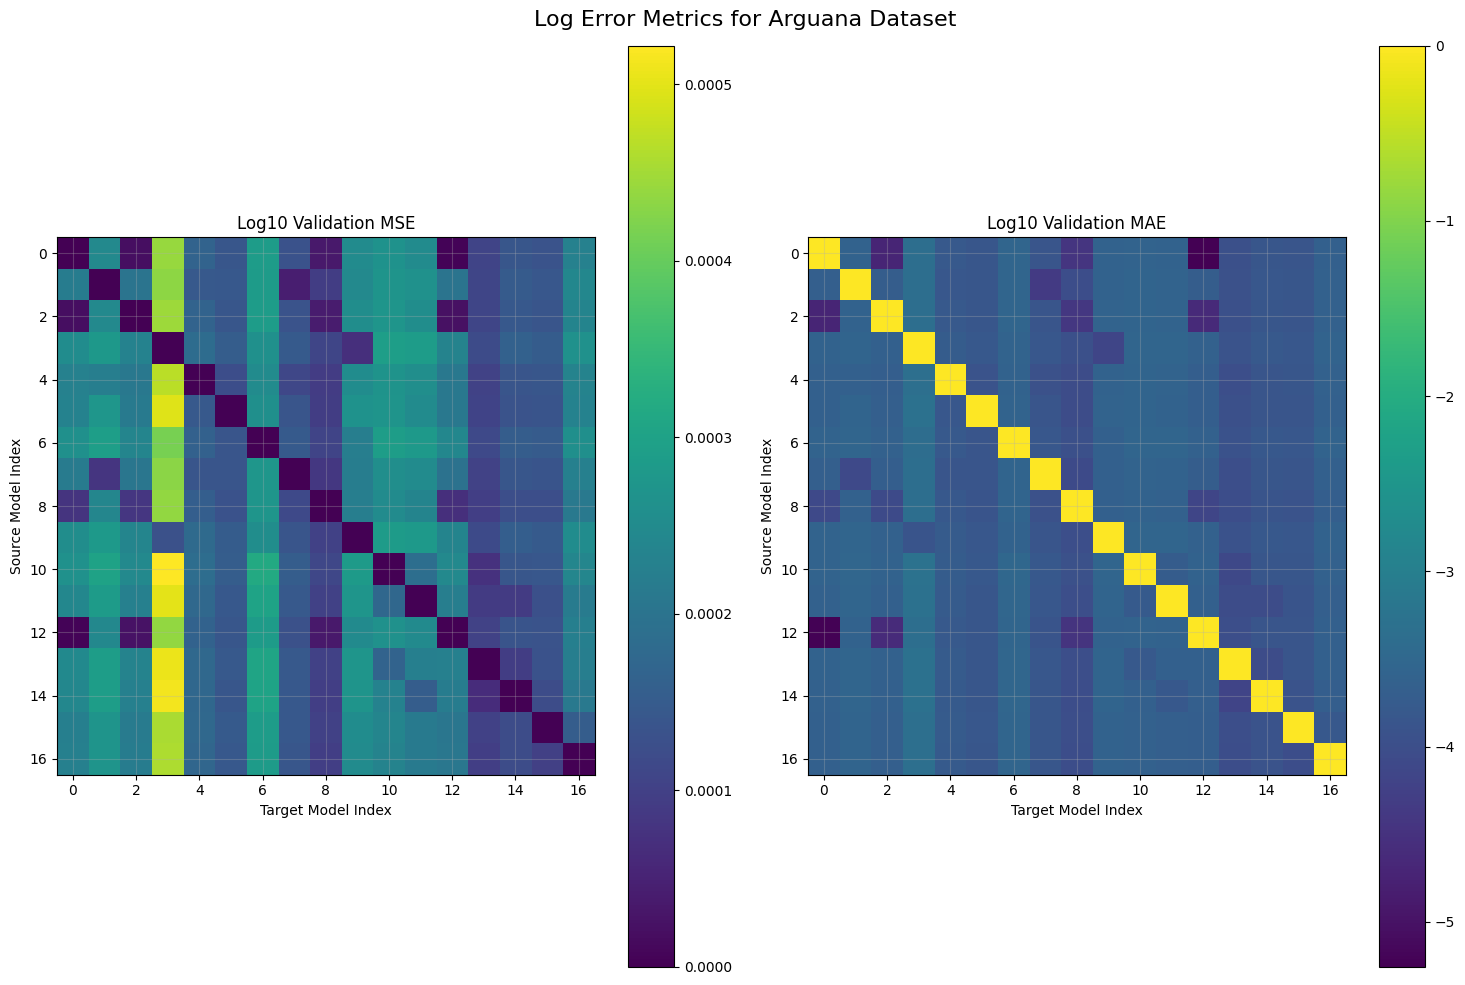

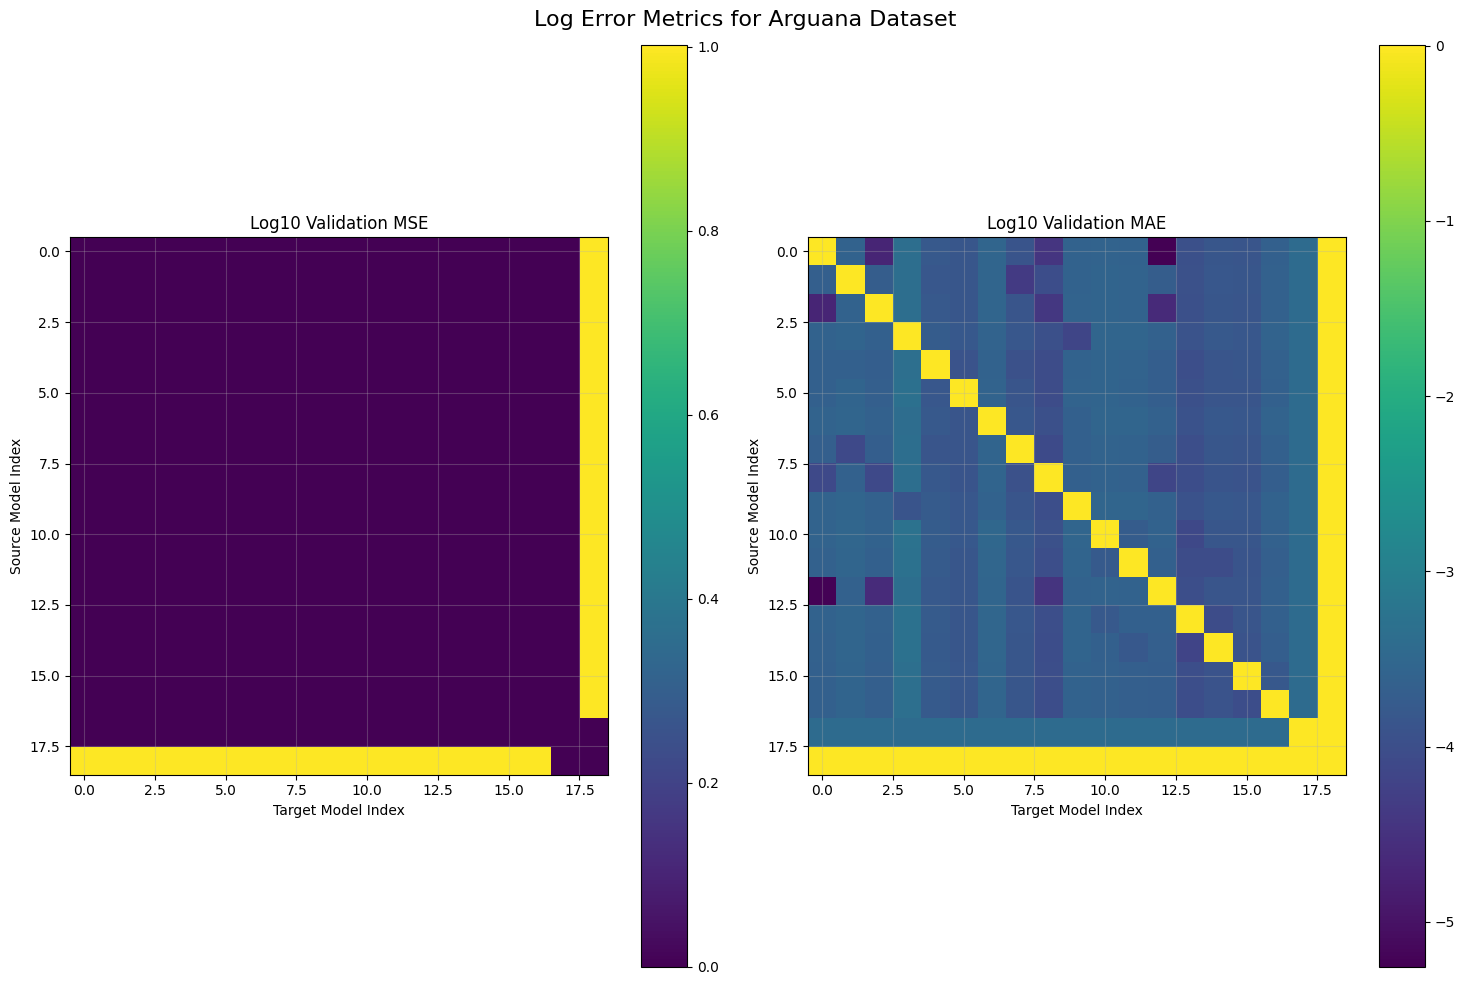

In [21]:
import einops
table = nnlinear_dataset2table_validation_mse["arguana"]
assert isinstance(table, torch.Tensor)
assert table.shape == (len(MODEL_NAMES), len(MODEL_NAMES))

def get_table_with_controls(
        table: torch.Tensor, 
        dataset_name: str, 
        all_variances_train: Dict[Tuple[str, str], float], 
        all_variances_validation: Dict[Tuple[str, str], float], 
        all_mse_wrt_gaussian01_train: Dict[Tuple[str, str], float], 
        all_mse_wrt_gaussian01_validation: Dict[Tuple[str, str], float],
        desired_model_order_names: List[str],
        permutation: torch.Tensor,
        diagonal_value: float = 0.0,
    ) -> Tuple[torch.Tensor, List[str]]:
    """
    Create controls:
    - Mean estimator
    - N(0, 1)
    """
    assert table.shape == (len(desired_model_order_names), len(desired_model_order_names)), f"table.shape: {table.shape}, desired_model_order_names: {desired_model_order_names}"
    assert len(desired_model_order_names) == len(permutation), f"len(desired_model_order_names): {len(desired_model_order_names)}, permutation: {permutation}"
    variances_train_pt = torch.Tensor([all_variances_train[(dataset_name, model_name)] for model_name in desired_model_order_names])
    variances_validation_pt = torch.Tensor([all_variances_validation[(dataset_name, model_name)] for model_name in desired_model_order_names])
    mse_wrt_gaussian01_train_pt = torch.Tensor([all_mse_wrt_gaussian01_train[(dataset_name, model_name)] for model_name in desired_model_order_names])
    mse_wrt_gaussian01_validation_pt = torch.Tensor([all_mse_wrt_gaussian01_validation[(dataset_name, model_name)] for model_name in desired_model_order_names])

    variances_pt = (variances_train_pt + variances_validation_pt) / 2
    mse_wrt_gaussian01_pt = (mse_wrt_gaussian01_train_pt + mse_wrt_gaussian01_validation_pt) / 2
    assert len(variances_pt) == len(desired_model_order_names), f"len(variances_pt): {len(variances_pt)}, desired_model_order_names: {desired_model_order_names}"
    assert len(mse_wrt_gaussian01_pt) == len(desired_model_order_names), f"len(mse_wrt_gaussian01_pt): {len(mse_wrt_gaussian01_pt)}, desired_model_order_names: {desired_model_order_names}"

    # add as a new row
    concat_tensor = torch.cat([variances_pt.unsqueeze(0), mse_wrt_gaussian01_pt.unsqueeze(0)], dim=0)
    assert concat_tensor.shape == (2, len(desired_model_order_names))
    table = torch.cat([table, concat_tensor], dim=0)
    assert table.shape == (len(desired_model_order_names) + 2, len(desired_model_order_names)), f"table.shape: {table.shape}, desired_model_order_names: {desired_model_order_names}"
    # add as a new column
    # 1. add a 2x2 to the concat tensor that has an expected diagonal everywhere and should be ignored
    _2x2 = torch.ones(2, 2) * diagonal_value
    concat_tensor = torch.cat([concat_tensor, _2x2], dim=1)
    concat_tensor = einops.rearrange(concat_tensor, "d1 d2 -> d2 d1")
    assert concat_tensor.shape == (len(desired_model_order_names) + 2, 2), f"concat_tensor.shape: {concat_tensor.shape}, desired_model_order_names: {desired_model_order_names}"
    table = torch.cat([table, concat_tensor], dim=1)
    assert table.shape == (len(desired_model_order_names) + 2, len(desired_model_order_names) + 2), f"table.shape: {table.shape}, desired_model_order_names: {desired_model_order_names}"
    new_names = desired_model_order_names + ["Mean_estimator", "Random_estimator"]
    return table, new_names

table_w_controls, new_names = get_table_with_controls(
    table,
    "arguana",
    all_variances_train,
    all_variances_validation,
    all_mse_wrt_gaussian01_train,
    all_mse_wrt_gaussian01_validation,
    DESIRED_MODEL_ORDER_NAMES,
    sort_permutation,
    diagonal_value=0.0,
    insert_numbers=False,
)

visualize_plt_heatmap("arguana", table, table, use_log_plot=False, show_plot=True, add_text_annotations=False)
visualize_plt_heatmap("arguana", table_w_controls, table_w_controls, use_log_plot=False, show_plot=True, add_text_annotations=False)
# fig = gatlen_default_heatmap_plot(nnlinear_idx2model, "arguana", "nnlinear", table, sort_permutation=sort_permutation) # XXX get this to work!
# save_figure(fig, "arguana_nnlinear_mse_validation")
# fig.show()

In [23]:
# Path.cwd() # [DEBUG] -> in commands
# plot without log
import shutil
plots_folder = Path.cwd().parent / "plots"
CLEAR_PREVIOUS_PLOTS = True
if CLEAR_PREVIOUS_PLOTS and plots_folder.exists():
    shutil.rmtree(plots_folder)
plots_folder.mkdir(parents=True, exist_ok=True)
DISPLAY = True
for dataset_name in tqdm.tqdm(DATASETS):
    # _ = visualize_plt_heatmap(
    #     dataset_name,
    #     nnlinear_dataset2table_validation_mse[dataset_name],
    #     nnlinear_dataset2table_validation_mae[dataset_name],
    #     use_log_plot=False,
    #     save_path=plots_folder / f"{dataset_name}_nnlinear_msemae_withoutlog.png", # _ seperates
    #     show_plot=DISPLAY
    # )
    fig_mse_withoutlog = gatlen_default_heatmap_plot(nnlinear_idx2model, dataset_name, "nnlinear", nnlinear_dataset2table_validation_mse[dataset_name], do_log=False)
    fig_mae_withoutlog = gatlen_default_heatmap_plot(nnlinear_idx2model, dataset_name, "nnlinear", nnlinear_dataset2table_validation_mae[dataset_name], do_log=False)
    fig_mse_withlog = gatlen_default_heatmap_plot(nnlinear_idx2model, dataset_name, "nnlinear", nnlinear_dataset2table_validation_mse[dataset_name], do_log=True)
    fig_mae_withlog = gatlen_default_heatmap_plot(nnlinear_idx2model, dataset_name, "nnlinear", nnlinear_dataset2table_validation_mae[dataset_name], do_log=True)
    save_figure(fig_mse_withoutlog, f"{dataset_name}_nnlinear_mse_withoutlog_validation")
    save_figure(fig_mae_withoutlog, f"{dataset_name}_nnlinear_mae_withoutlog_validation")
    save_figure(fig_mse_withlog, f"{dataset_name}_nnlinear_mse_withlog_validation")
    save_figure(fig_mae_withlog, f"{dataset_name}_nnlinear_mae_withlog_validation")
print("Done")

  0%|          | 0/6 [00:00<?, ?it/s]2024-12-11 19:50:24.753 | INFO     | __main__:visualize_heatmap:127 - Starting heatmap visualization process
2024-12-11 19:50:24.754 | INFO     | __main__:_plot_heatmap:52 - Creating heatmap visualization...
2024-12-11 19:50:24.764 | SUCCESS  | __main__:_plot_heatmap:101 - Heatmap created successfully
2024-12-11 19:50:24.765 | INFO     | __main__:visualize_heatmap:127 - Starting heatmap visualization process
2024-12-11 19:50:24.765 | INFO     | __main__:_plot_heatmap:52 - Creating heatmap visualization...
2024-12-11 19:50:24.774 | SUCCESS  | __main__:_plot_heatmap:101 - Heatmap created successfully
2024-12-11 19:50:24.775 | INFO     | __main__:visualize_heatmap:127 - Starting heatmap visualization process
2024-12-11 19:50:24.776 | INFO     | __main__:_plot_heatmap:52 - Creating heatmap visualization...
2024-12-11 19:50:24.785 | SUCCESS  | __main__:_plot_heatmap:101 - Heatmap created successfully
2024-12-11 19:50:24.786 | INFO     | __main__:visualiz

Done


In [24]:
# # plot with log
# DISPLAY = False
# for dataset_name in tqdm.tqdm(DATASETS):
#     _ = visualize_plt_heatmap(
#         dataset_name,
#         nnlinear_dataset2table_validation_mse[dataset_name],
#         nnlinear_dataset2table_validation_mae[dataset_name],
#         use_log_plot=True,
#         save_path=plots_folder / f"{dataset_name}_nnlinear_msemae_withlog.png", # _ seperates
#         show_plot=DISPLAY
#     )
# print("Done")


In [25]:
(
    ols_model2idx,
    ols_idx2model,
    ols_dataset2table_train_mse,
    ols_dataset2table_validation_mse,
    ols_dataset2table_train_mae,
    ols_dataset2table_validation_mae
) = creator2.get_all_table_elements()
# plot with log
DISPLAY = False
for dataset_name in DATASETS:
    # visualize_plt_heatmap(
    #     dataset_name,
    #     ols_dataset2table_validation_mse[dataset_name],
    #     ols_dataset2table_validation_mae[dataset_name],
    #     use_log_plot=True,
    #     save_path=plots_folder / f"{dataset_name}_olsaffine_msemae_withlog.png", # _ seperates
    #     show_plot=DISPLAY
    # )
    fig_mse_withoutlog = gatlen_default_heatmap_plot(ols_idx2model, dataset_name, "olsaffine", ols_dataset2table_validation_mse[dataset_name], do_log=False)
    fig_mae_withoutlog = gatlen_default_heatmap_plot(ols_idx2model, dataset_name, "olsaffine", ols_dataset2table_validation_mae[dataset_name], do_log=False)
    fig_mse_withlog = gatlen_default_heatmap_plot(ols_idx2model, dataset_name, "olsaffine", ols_dataset2table_validation_mse[dataset_name], do_log=True)
    fig_mae_withlog = gatlen_default_heatmap_plot(ols_idx2model, dataset_name, "olsaffine", ols_dataset2table_validation_mae[dataset_name], do_log=True)
    save_figure(fig_mse_withoutlog, f"{dataset_name}_olsaffine_mse_withoutlog_validation")
    save_figure(fig_mae_withoutlog, f"{dataset_name}_olsaffine_mae_withoutlog_validation")
    save_figure(fig_mse_withlog, f"{dataset_name}_olsaffine_mse_withlog_validation")
    save_figure(fig_mae_withlog, f"{dataset_name}_olsaffine_mae_withlog_validation")
print("Done")
# for dataset_name in DATASETS:
#     visualize_plt_heatmap(
#         dataset_name,
#         ols_dataset2table_validation_mse[dataset_name],
#         ols_dataset2table_validation_mae[dataset_name],
#         use_log_plot=False,
#         save_path=plots_folder / f"{dataset_name}_olsaffine_msemae_withoutlog.png", # _ seperates
#         show_plot=DISPLAY
#     )



100%|██████████| 1632/1632 [00:00<00:00, 15352.41it/s]
2024-12-11 19:50:39.481 | INFO     | __main__:visualize_heatmap:127 - Starting heatmap visualization process
2024-12-11 19:50:39.482 | INFO     | __main__:_plot_heatmap:52 - Creating heatmap visualization...
2024-12-11 19:50:39.487 | SUCCESS  | __main__:_plot_heatmap:101 - Heatmap created successfully
2024-12-11 19:50:39.488 | INFO     | __main__:visualize_heatmap:127 - Starting heatmap visualization process
2024-12-11 19:50:39.489 | INFO     | __main__:_plot_heatmap:52 - Creating heatmap visualization...
2024-12-11 19:50:39.496 | SUCCESS  | __main__:_plot_heatmap:101 - Heatmap created successfully
2024-12-11 19:50:39.497 | INFO     | __main__:visualize_heatmap:127 - Starting heatmap visualization process
2024-12-11 19:50:39.498 | INFO     | __main__:_plot_heatmap:52 - Creating heatmap visualization...
2024-12-11 19:50:39.503 | SUCCESS  | __main__:_plot_heatmap:101 - Heatmap created successfully
2024-12-11 19:50:39.504 | INFO     |

Done


In [26]:
import einops
dataset_sizes = {
    "arguana": 10000,
    "fiqa": 50000,
    "scidocs": 25000,
    "nfcorpus": 5000,
    "hotpotqa": 100000,
    "trec-covid": 20000,
}
proportions = torch.tensor([dataset_sizes[x] for x in DATASETS])
proportions = proportions / proportions.sum()
proportions = einops.rearrange(proportions, "d -> d 1 1")
assert proportions.sum() == 1.0
# 1. Stack
nnlinear_mse_validation_tables = torch.stack([nnlinear_dataset2table_validation_mse[x] for x in DATASETS])
nnlinear_mse_train_tables = torch.stack([nnlinear_dataset2table_train_mse[x] for x in DATASETS])
nnlinear_mae_validation_tables = torch.stack([nnlinear_dataset2table_validation_mae[x] for x in DATASETS])
nnlinear_mae_train_tables = torch.stack([nnlinear_dataset2table_train_mae[x] for x in DATASETS])
ols_mse_validation_tables = torch.stack([ols_dataset2table_validation_mse[x] for x in DATASETS])
ols_mse_train_tables = torch.stack([ols_dataset2table_train_mse[x] for x in DATASETS])
ols_mae_validation_tables = torch.stack([ols_dataset2table_validation_mae[x] for x in DATASETS])
ols_mae_train_tables = torch.stack([ols_dataset2table_train_mae[x] for x in DATASETS])
# 2. Scale
nnlinear_scaled_mse_validation_tables = nnlinear_mse_validation_tables * proportions
nnlinear_scaled_mse_train_tables = nnlinear_mse_train_tables * proportions
nnlinear_scaled_mae_validation_tables = nnlinear_mae_validation_tables * proportions
nnlinear_scaled_mae_train_tables = nnlinear_mae_train_tables * proportions
ols_scaled_mse_validation_tables = ols_mse_validation_tables * proportions
ols_scaled_mse_train_tables = ols_mse_train_tables * proportions
ols_scaled_mae_validation_tables = ols_mae_validation_tables * proportions
ols_scaled_mae_train_tables = ols_mae_train_tables * proportions
# 3. Sum
nnlinear_mean_mse_validation_table = nnlinear_scaled_mse_validation_tables.sum(dim=0)
nnlinear_mean_mse_train_table = nnlinear_scaled_mse_train_tables.sum(dim=0)
nnlinear_mean_mae_validation_table = nnlinear_scaled_mae_validation_tables.sum(dim=0)
nnlinear_mean_mae_train_table = nnlinear_scaled_mae_train_tables.sum(dim=0)
ols_mean_mse_validation_table = ols_scaled_mse_validation_tables.sum(dim=0)
ols_mean_mse_train_table = ols_scaled_mse_train_tables.sum(dim=0)
ols_mean_mae_validation_table = ols_scaled_mae_validation_tables.sum(dim=0)
ols_mean_mae_train_table = ols_scaled_mae_train_tables.sum(dim=0)
assert nnlinear_mean_mse_validation_table.shape == nnlinear_mean_mse_train_table.shape == nnlinear_mean_mae_validation_table.shape == nnlinear_mean_mae_train_table.shape == (len(MODEL_NAMES), len(MODEL_NAMES))
assert ols_mean_mse_validation_table.shape == ols_mean_mse_train_table.shape == ols_mean_mae_validation_table.shape == ols_mean_mae_train_table.shape == (len(MODEL_NAMES), len(MODEL_NAMES))
# 4. Plot
DISPLAY = False
# visualize_plt_heatmap(
#     "mean",
#     nnlinear_mean_mse_validation_table,
#     nnlinear_mean_mae_validation_table,
#     use_log_plot=False,
#     save_path=plots_folder / f"weightedmean_nnlinear_msemae_withoutlog.png",
#     show_plot=DISPLAY
# )
# visualize_plt_heatmap(
#     "mean",
#     ols_mean_mse_validation_table,
#     ols_mean_mae_validation_table,
#     use_log_plot=False,
#     save_path=plots_folder / f"weightedmean_olsaffine_msemae_withoutlog.png",
#     show_plot=DISPLAY
# )
fig_mse_withoutlog = gatlen_default_heatmap_plot(ols_idx2model, "mean", "olsaffine", ols_mean_mse_validation_table, do_log=False)
fig_mae_withoutlog = gatlen_default_heatmap_plot(ols_idx2model, "mean", "olsaffine", ols_mean_mae_validation_table, do_log=False)
fig_mse_withlog = gatlen_default_heatmap_plot(ols_idx2model, "mean", "olsaffine", ols_mean_mse_validation_table, do_log=True)
fig_mae_withlog = gatlen_default_heatmap_plot(ols_idx2model, "mean", "olsaffine", ols_mean_mae_validation_table, do_log=True)
save_figure(fig_mse_withoutlog, f"weightedmean_olsaffine_mse_withoutlog_validation")
save_figure(fig_mae_withoutlog, f"weightedmean_olsaffine_mae_withoutlog_validation")
save_figure(fig_mse_withlog, f"weightedmean_olsaffine_mse_withlog_validation")
save_figure(fig_mae_withlog, f"weightedmean_olsaffine_mae_withlog_validation")


2024-12-11 19:50:47.588 | INFO     | __main__:visualize_heatmap:127 - Starting heatmap visualization process
2024-12-11 19:50:47.589 | INFO     | __main__:_plot_heatmap:52 - Creating heatmap visualization...
2024-12-11 19:50:47.598 | SUCCESS  | __main__:_plot_heatmap:101 - Heatmap created successfully
2024-12-11 19:50:47.599 | INFO     | __main__:visualize_heatmap:127 - Starting heatmap visualization process
2024-12-11 19:50:47.600 | INFO     | __main__:_plot_heatmap:52 - Creating heatmap visualization...
2024-12-11 19:50:47.609 | SUCCESS  | __main__:_plot_heatmap:101 - Heatmap created successfully
2024-12-11 19:50:47.610 | INFO     | __main__:visualize_heatmap:127 - Starting heatmap visualization process
2024-12-11 19:50:47.611 | INFO     | __main__:_plot_heatmap:52 - Creating heatmap visualization...
2024-12-11 19:50:47.620 | SUCCESS  | __main__:_plot_heatmap:101 - Heatmap created successfully
2024-12-11 19:50:47.621 | INFO     | __main__:visualize_heatmap:127 - Starting heatmap visu

(PosixPath('data/figs/html/weightedmean_olsaffine_mae_withlog_validation.html'),
 PosixPath('data/figs/imgs/weightedmean_olsaffine_mae_withlog_validation.png'))